In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import scipy.io as sio #to load mat files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

<h1> 1. Loading CMU Faces dataset </h1>

In [2]:
print sio.whosmat('../datasets/CMU(30x11x21x1024).mat')
matTF = sio.loadmat('../datasets/CMU(30x11x21x1024).mat')#loading tensor of formatted faces' images
TF = matTF['FullTensor']
print TF.shape
MF = np.reshape(TF,(30*11*21,1024))
print MF.shape

[('FullTensor', (30, 11, 21, 1024), 'uint8')]
(30, 11, 21, 1024)
(6930, 1024)


<h2> Preprocessing incomplete objects </h2>

In [18]:
rt_obinc = 0.92 # rate of objects incomplete
rt_incpob = 0.5 # rate of minimun elements (attributes or variables) incomplete for each object
idx_inc = np.sort(np.random.choice(MF.shape[0], int(MF.shape[0]*rt_obinc), replace=False))
idx_v = np.ones(MF.shape[0])
idx_v[idx_inc] = 0
idx_s = np.vstack((idx_v,idx_v)).repeat([1,MF.shape[1]-1],0).T
idx_com = np.arange(0,MF.shape[0]-1)
idx_com = np.delete(idx_com, idx_inc)

In [19]:
idx_s2 = np.copy(idx_s) # idx_s2 could have partially incomplete objects
for i in idx_inc:
    idx_s2[i] = np.random.permutation(np.append(np.ones(int(round(MF.shape[1]*(1-rt_incpob)))),np.zeros(int(round(MF.shape[1]*rt_incpob)))))

print round(MF.shape[1]*rt_incpob)

512.0


In [20]:
MF_ci = MF * idx_s2
MF_i = MF_ci[idx_inc]#subset with incomplete elements
MF_c = MF_ci[idx_com]#subset with complete elements
#plt.pcolor(MF_ci)
#plt.colorbar()

In [21]:
print 'Complete pixels:', sum(idx_s2[idx_inc[10]])

Complete pixels: 512.0


<h1>2. Kernel Completion Using Convex-NMF </h1>

In [22]:
import kernel as kernel
import pymf
from pymf.cnmf import CNMF 
from kcnmf import KCNMF 
import time

Computing tensorial kernels

In [23]:
#kernels parameters
eq = 1
diff = 0.3

sigmas = 10.5
sigmal = 2000#1500.0 #100.0#1.6#
sigmap = 350.5#1000.0#4.5#
sigmai = 500.0#1000.0#10000.0#1000#

mask = 1

chooseks = 1
choosekl = 1
choosekp = 1
chooseki = 1

bases = 30
normalize = 3

#objects: 555
Ks size: (555, 555)
Kl size: (555, 555)
Kp size: (555, 555)
Ki size: (555, 555)


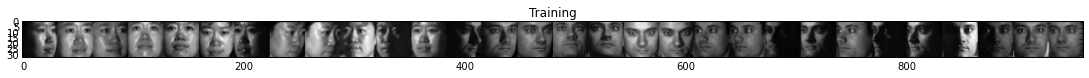

In [24]:
#30x11x21x1024
#completes = np.arange(35,MF.shape[0],11*21)#fixing all modes except subject
#completes = np.arange(10,MF.shape[0],21)#fixing all modes except subject and pose
#completes = np.arange(0,11*21)#fixing one subject
#completes = np.arange(0,11*21,6)#fixing one subject
completes = np.arange(0,MF.shape[0],21)#fixing illumination*
#completes = np.random.permutation(idx_com)#sample of whole complete objects
#completes = completes[range(500)]
#completes = idx_com
MF_sm = MF[completes]
#MF_sm = MF
#Kernels
poses = [175, 95, 93, 88, 10, 5, 180, 90, 80, 2, 170]
illuminations = np.arange(1,22)
nobj = len(completes)
print '#objects:', nobj
Ksm_g = np.ones((nobj,nobj))

if chooseks == 1:
    #Kernel for subject
    #30x11x21x1024
    TS = np.zeros((30,11,21))
    for i in range(30):
        for j in range(len(poses)):
            for k in range(len(illuminations)):
                TS[i,j,k] = i

    MS = np.reshape(TS,(30*11*21,1))
    #Ks = np.identity(nobj)*eq
    #Ks[Ks==0] = diff
    Ks = np.zeros((nobj,nobj))
    for i in xrange(len(completes)):
        for j in xrange(i, len(completes)):
            if MS[completes[i]]==MS[completes[j]]:
                Ks[i,j], Ks[j,i] = eq,eq
            else:
                Ks[i,j], Ks[j,i] = diff,diff
    print 'Ks size:', Ks.shape
    Ksm_g *= Ks
    #Ksm_g = Ks
if choosekl == 1:
    #Illumination Kernel
    TL_ = np.repeat(np.array(np.arange(1,22), ndmin = 2),11,axis=0)
    TL = np.repeat(np.array(TL_,ndmin = 3),30,axis=0)
    ML = np.reshape(TL,(30*11*21,1))
    ML_c = ML[completes]
    Kl = kernel._get_kernel(ML_c, ML_c,'rbf', gamma=(2*sigmal)**-2)    
    print 'Kl size:', Kl.shape
    Ksm_g *= Kl
if choosekp == 1:
    TP_ = np.repeat(np.array([175, 95, 93, 88, 10, 5, 180, 90, 80, 2, 170], ndmin = 2),21,axis=0)
    TP = np.repeat(np.array(TP_.T,ndmin = 3),30,axis=0)
    MP = np.reshape(TP,(30*11*21,1))
    MP_c = MP[completes]
    Kp = kernel._get_kernel(MP_c, MP_c,'rbf', gamma=(2*sigmap)**-2)
    print 'Kp size:', Kp.shape
    Ksm_g *= Kp
    #Ksm_g = np.dot(Ksm_g,Kp) 
if chooseki == 1:    
    #image kernel    
    Ki = kernel._get_kernel(MF_sm, MF_sm, 'rbf', gamma=(2*sigmai)**-2)
    print 'Ki size:', Ki.shape
    Ksm_g *= Ki
#tensorial kernel
#Ksm_g

#Factorize
cnmf_ksmg = KCNMF(Ksm_g,num_bases=bases)
cnmf_ksmg.factorize(niter=10)
print '(rbf kernel) rse:',np.linalg.norm(Ksm_g - np.dot(cnmf_ksmg.W,cnmf_ksmg.H))/np.linalg.norm(Ksm_g)
f, axarr = plt.subplots(1, 1+chooseks+choosekl+choosekp+chooseki)
i=0
if chooseks == 1:
    axarr[i].pcolor(Ks)
    axarr[i].set_title('Subject')
    i+=1
if choosekl == 1:    
    axarr[i].pcolor(Kl)
    axarr[i].set_title('Illumination')
    i+=1
if choosekp == 1:    
    axarr[i].pcolor(Kp)
    axarr[i].set_title('Pose')
    i+=1
if chooseki == 1:    
    axarr[i].pcolor(Ki)
    axarr[i].set_title('Image')
    i+=1
axarr[i].pcolor(Ksm_g)
axarr[i].set_title('Tensorial')
    
f.set_size_inches(19,3)
plt.pcolor(Ksm_g)
plt.colorbar()
#Faces for Training
fig = plt.figure(figsize=(19,3))
plt.imshow( np.reshape(MF_sm[range(30)],(30*32,32)).T, cmap='Greys_r' )
plt.title('Training')


In [30]:
cnmf_ksmg = KCNMF(Ksm_g,num_bases=bases)
cnmf_ksmg.factorize(niter=10)
print '(rbf kernel) rse:',np.linalg.norm(Ksm_g - np.dot(cnmf_ksmg.W,cnmf_ksmg.H))/np.linalg.norm(Ksm_g)

(rbf kernel) rse: 0.645684947174


In [27]:
#zoom kernel
#print 'poses:', [175, 95, 93, 88, 10, 5, 180, 90, 80, 2, 170]
#plt.figure(figsize=(19,19))
#plt.pcolor(Kp)
#plt.colorbar()

In [9]:
test = np.arange(10,MF.shape[0],21)
test = np.random.permutation(test)

In [31]:
#experiments (testing)
#incompletes = idx_inc[np.arange(0,30)]
#incompletes = np.arange(29, MF.shape[0], 11*21)
#incompletes = np.arange(1, MF.shape[0], 21)#*fixing illumination
#incompletes = test
incompletes = idx_inc
#incompletes = incompletes[range(30)]
print incompletes
print MF[incompletes].shape

f, axarr = plt.subplots(2, 1)
axarr[0].imshow( np.reshape(MF[incompletes],(len(incompletes)*32,32)).T, cmap='Greys_r' )
axarr[0].set_title('Original')
axarr[1].imshow( np.reshape(MF_ci[incompletes],(len(incompletes)*32,32)).T, cmap='Greys_r' )
axarr[1].set_title('Incomplete')
f.set_size_inches(19,3)
f.savefig('/home/rajaquep/outcomes/foo.png')

[   0    1    2 ..., 6927 6928 6929]
(6375, 1024)


In [32]:
lamb = 1e-10
print 'Computing Hs...'
H4_i = np.zeros((bases, len(incompletes)))
for i in range(len(incompletes)):
    auxpi4 = np.linalg.inv(np.dot(cnmf_ksmg.W.T, cnmf_ksmg.G)+ lamb*np.identity(bases))
    Ktx = np.ones((nobj,1))
    gamma_t = 0 #preimage
    if chooseks == 1:
        Ksx = np.zeros((nobj,1))
        for j in range(nobj):
            if MS[incompletes[i]]==MS[completes[j]]: Ksx[j] = eq
            else: Ksx[j] = diff    
        Ktx *= Ksx
        #gamma_t += (2*sigmas)**-2#preimage
    if choosekl == 1:
        Klx = kernel._get_kernel(ML_c, ML[i],'rbf', gamma=(2*sigmal)**-2)
        Ktx *= Klx
        gamma_t += (2*sigmal)**-2#preimage
    if choosekp == 1:
        Kpx = kernel._get_kernel(MP_c, MP[i],'rbf', gamma=(2*sigmap)**-2)
        Ktx *= Kpx
        gamma_t += (2*sigmap)**-2#preimage
    if chooseki == 1:
        if mask == 1:
            Kix = kernel._get_kernel(idx_s2[incompletes[i]]*MF_sm, MF_ci[incompletes[i]],'rbf', gamma=(2*sigmai)**-2)#complete image
        else:
            Kix = kernel._get_kernel(MF_sm, MF_ci[incompletes[i]], 'rbf', gamma=(2*sigmai)**-2)
        #print 'Ki:', Kix, Kix2
        Ktx *= Kix
        gamma_t += (2*sigmai)**-2#preimage
    #Ktx = Ksx+Kix
    H4_i[:,i] = np.squeeze(np.dot(auxpi4, np.dot(cnmf_ksmg.G.T, Ktx) ))
    if normalize == 1:
        H4_i[:,i] = (H4_i[:,i]+abs(min(H4_i[:,i]))) / sum(H4_i[:,i]+abs(min(H4_i[:,i])))
    if normalize == 2:
        H4_i[:,i] = abs(H4_i[:,i])
    if normalize == 3:
        H4_i[:,i] = np.maximum(H4_i[:,i],0)
print '...Hs computed'
print 'Computing pre-image...'
MFpreim_ci = np.copy(MF_ci)
rse_f = []
for i in range(len(incompletes)):
    print 'Compute pre-image for object',incompletes[i]
    alpha = np.dot(cnmf_ksmg.G, H4_i[:,i]) #np.mean(cnmf_kg.H,0)        
    try:        
        #MFpreim_ci[incompletes[i]], trainErrorskl = kernel.preimage(MF_sm, alpha, 'rbf', gamma=(2*sigmas)**-2+(2*sigmai)**-2)
        MFpreim_ci[incompletes[i]], trainErrorskl = kernel.preimage(MF_sm, alpha, 'rbf', gamma=gamma_t)
        rse_f.append(np.linalg.norm(MF[incompletes[i]] - MFpreim_ci[incompletes[i]])/np.linalg.norm(MF[incompletes[i]]))
    except:
        print 'Problems computing preimage', i
        continue    
print '...pre-images computed'

Computing Hs...
...Hs computed
Computing pre-image...
Compute pre-image for object 0
Compute pre-image for object 1
Compute pre-image for object 2
Compute pre-image for object 3
Compute pre-image for object 5
Compute pre-image for object 6
Compute pre-image for object 7
Compute pre-image for object 8
Compute pre-image for object 9
Compute pre-image for object 10
Compute pre-image for object 11
Compute pre-image for object 12
Compute pre-image for object 13
Compute pre-image for object 14
Compute pre-image for object 15
Compute pre-image for object 16
Compute pre-image for object 17
Compute pre-image for object 18
Compute pre-image for object 19
Compute pre-image for object 20
Compute pre-image for object 21
Compute pre-image for object 22
Compute pre-image for object 23
Compute pre-image for object 24
Compute pre-image for object 25
Compute pre-image for object 26
Compute pre-image for object 28
Compute pre-image for object 29
Compute pre-image for object 30
Compute pre-image for objec

[ 7.42785628  3.18550819  6.79130388  7.66885224  2.5502123   1.74699906
  7.45887816  3.20880683  3.32724564  5.56558003  4.11205873  3.47932366
  4.58009453  7.20575955  3.18340214  2.75444554  2.5162425   2.76043246
  7.36815819  2.88554087  5.125792    3.37441636  3.56035147  3.49482986
  3.42423138  3.23513276  5.98240891  2.27819483  7.12708342  7.26511157]


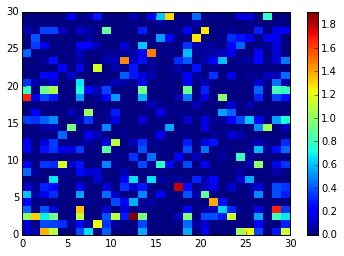

In [47]:
plt.pcolor(H4_i)
plt.colorbar()
#plt.savefig('/home/rajaquep/outcomes/testH.png')
print sum(H4_i)

[ 5.83029253  6.15173999  0.66456182  6.04638098  5.49038133  0.79045266
  0.58940551  0.79320725  0.6488214   5.35056373  6.91990118  5.61753219
  7.01268291  1.03036203  7.35170715  6.98791855  5.19988546  1.09979783
  1.11360007  6.99530126  0.93170886  7.36539702  1.05474698  0.63655941
  6.94226988  6.003502    0.90206116  0.77067013  6.78328671  7.47884138]


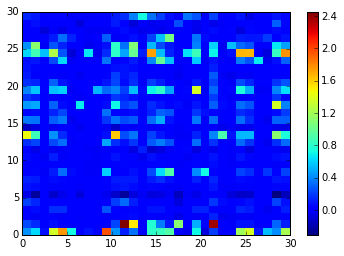

In [147]:
plt.pcolor(H4_i)
plt.colorbar()
print sum(H4_i)

RSE 0.727419565548
RSE** 0.31445951416
[0.60185939685982148, 0.64015258405122899, 0.72127038244728159, 0.74001011469781985, 0.81610762219564936, 0.85982486944924341, 0.57721586459083452, 0.705880167377547, 0.79955902114606292, 0.84713620376727616, 0.54754418913969294, 0.69277835290511458, 0.60835023367084773, 0.68499396217869579, 0.70577079110928431, 0.82515609211659091, 0.85297681554939797, 0.61294911580646672, 0.68467337096638936, 0.75829878678743035, 0.85516663646861812, 0.62913907856773976, 0.54484425603479991, 0.45928465354080633, 0.55953785992918192, 0.59886104041598232, 0.69498242834281643, 0.76786511409312386, 0.53696368333163014, 0.56323743028339679]


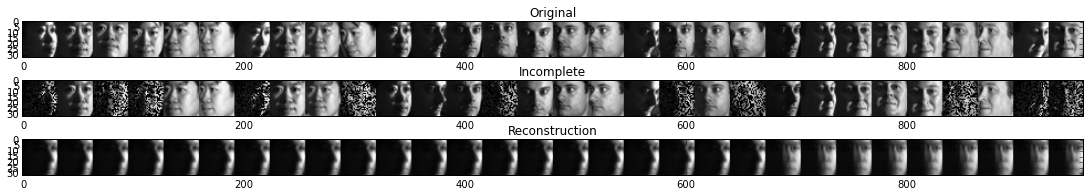

In [56]:
f, axarr = plt.subplots(3, 1)
axarr[0].imshow( np.reshape(MF[incompletes],(len(incompletes)*32,32)).T, cmap='Greys_r' )
axarr[0].set_title('Original')
axarr[1].imshow( np.reshape(MF_ci[incompletes],(len(incompletes)*32,32)).T, cmap='Greys_r' )
axarr[1].set_title('Incomplete')
axarr[2].imshow( np.reshape(MFpreim_ci[incompletes],(len(incompletes)*32,32)).T, cmap='Greys_r' )
axarr[2].set_title('Reconstruction')
f.set_size_inches(19,3)
f.savefig('/home/rajaquep/outcomes/foo.png')
print 'RSE', np.linalg.norm(MF[incompletes] - MFpreim_ci[incompletes])/np.linalg.norm(MF[incompletes])
#**compute RSE only on missing pixels 
inv_idx2 = idx_s2+1
inv_idx2[inv_idx2==2] = 0
print 'RSE**', np.linalg.norm(MF[incompletes] - ((MFpreim_ci[incompletes]*inv_idx2[incompletes])+MF_ci[incompletes]))/np.linalg.norm(MF[incompletes])
print rse_f

In [33]:
print 'RSE', np.linalg.norm(MF[incompletes] - MFpreim_ci[incompletes])/np.linalg.norm(MF[incompletes])
#**compute RSE only on missing pixels 
inv_idx2 = idx_s2+1
inv_idx2[inv_idx2==2] = 0
print 'RSE**', np.linalg.norm(MF[incompletes] - ((MFpreim_ci[incompletes]*inv_idx2[incompletes])+MF_ci[incompletes]))/np.linalg.norm(MF[incompletes])

RSE 0.519859219347
RSE** 0.36800139423


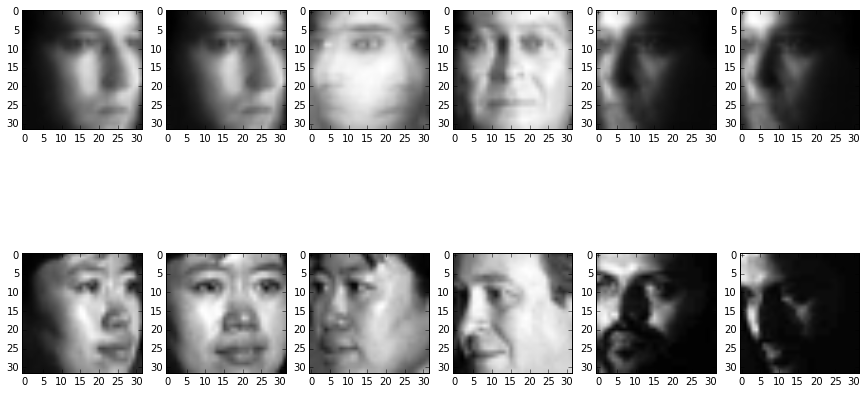

In [34]:
f, axarr = plt.subplots(2, 6)
axarr[0,0].imshow( np.reshape(MFpreim_ci[idx_inc[8],:],(32,32)).T, cmap='Greys_r' )
axarr[0,1].imshow( np.reshape(MFpreim_ci[idx_inc[36],:],(32,32)).T, cmap='Greys_r' )
axarr[0,2].imshow( np.reshape(MFpreim_ci[idx_inc[100],:],(32,32)).T, cmap='Greys_r' )
axarr[0,3].imshow( np.reshape(MFpreim_ci[idx_inc[600],:],(32,32)).T, cmap='Greys_r' )
axarr[0,4].imshow( np.reshape(MFpreim_ci[idx_inc[2000],:],(32,32)).T, cmap='Greys_r' )
axarr[0,5].imshow( np.reshape(MFpreim_ci[idx_inc[2100],:],(32,32)).T, cmap='Greys_r' )
axarr[1,0].imshow( np.reshape(MF[idx_inc[8],:],(32,32)).T, cmap='Greys_r' )
axarr[1,1].imshow( np.reshape(MF[idx_inc[36],:],(32,32)).T, cmap='Greys_r' )
axarr[1,2].imshow( np.reshape(MF[idx_inc[100],:],(32,32)).T, cmap='Greys_r' )
axarr[1,3].imshow( np.reshape(MF[idx_inc[600],:],(32,32)).T, cmap='Greys_r' )
axarr[1,4].imshow( np.reshape(MF[idx_inc[2000],:],(32,32)).T, cmap='Greys_r' )
axarr[1,5].imshow( np.reshape(MF[idx_inc[2100],:],(32,32)).T, cmap='Greys_r' )
f.set_size_inches(15,8)
#f.savefig('/home/rajaquep/outcomes/foo.png')

RSE 0.36800139423


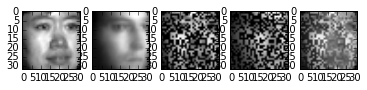

In [37]:
#**compute RSE only on missing pixels 
inv_idx2 = idx_s2+1
inv_idx2[inv_idx2==2] = 0
f, axarr = plt.subplots(1, 5)
axarr[0].imshow( np.reshape(MF[incompletes[28]],(32,32)).T, cmap='Greys_r' )
axarr[1].imshow( np.reshape(MFpreim_ci[incompletes[28]],(32,32)).T, cmap='Greys_r' )
axarr[2].imshow( np.reshape(MF_ci[incompletes[28]],(32,32)).T, cmap='Greys_r' )
axarr[3].imshow( np.reshape(MFpreim_ci[incompletes[28]]*inv_idx2[incompletes[28]],(32,32)).T, cmap='Greys_r' )
axarr[4].imshow( np.reshape((MFpreim_ci[incompletes[28]]*inv_idx2[incompletes[28]])+MF_ci[incompletes[28]],(32,32)).T, cmap='Greys_r' )
print 'RSE', np.linalg.norm(MF[incompletes] - ((MFpreim_ci[incompletes]*inv_idx2[incompletes])+MF_ci[incompletes]))/np.linalg.norm(MF[incompletes])

<matplotlib.colorbar.Colorbar instance at 0x7fb32adc2290>

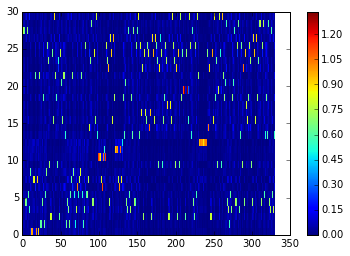

In [381]:
plt.pcolor(cnmf_ksmg.H)
plt.colorbar()

In [382]:
sum(cnmf_ksmg.H)

array([ 1.63251121,  1.83141342,  1.83696053,  1.77142069,  1.54398102,
        1.49587355,  1.48959988,  1.82875103,  1.70256131,  1.41337079,
        1.81864701,  1.84751585,  1.96835976,  1.85327934,  1.90149736,
        1.46989297,  1.48401057,  1.66703022,  1.90951542,  1.71092981,
        1.41998776,  1.88362941,  1.71104163,  1.87790906,  1.8802559 ,
        1.89840027,  1.55232869,  1.51843679,  1.5877738 ,  1.9184184 ,
        1.76300722,  1.53875187,  1.86143314,  1.26402042,  1.66823794,
        1.71477745,  1.58492563,  1.60413184,  1.445064  ,  1.06019972,
        1.67549337,  1.67418693,  1.44988209,  1.59116478,  1.35342309,
        1.62171547,  1.70428826,  1.56026057,  1.62560891,  1.50865462,
        1.18398414,  1.83285382,  1.69753311,  1.43925336,  1.63205519,
        1.72516638,  1.84879685,  1.8586337 ,  1.7936557 ,  1.47480538,
        1.46042829,  1.6712498 ,  1.85629991,  1.68113265,  1.28578731,
        1.82539832,  1.74958487,  1.94292103,  1.80698521,  1.83

In [6]:
#systhematic experiments
test = np.arange(10,MF.shape[0],21)
test = np.random.permutation(test)

training = np.random.permutation(idx_com)#sample of whole complete objects
training = training[range(500)]

In [ ]:
#systhematic experiments
import test_kcnmf
#subject
vdiff=[0.7]#, 0.7
#pose
vsigmal=[1000]#vsigmal=[10, 20, 50, 150.5, 350.5, 500, 800, 1000, 1200, 1500, 1800, 2000, 2100, 2500, 3000]
#image
vsigmai=[10.0, 100.0, 500.0, 1000.0, 1100.0, 1500.0, 2000.0]
#mask
vmask=[1]
#normalize
vnormalize = [0, 1, 2]


#training = np.arange(10,MF.shape[0],21)
#test = np.arange(15,MF.shape[0],21)#fixing illumination
#test = np.arange(11,MF.shape[0],21)

test_kcnmf.testTensorialKspi(MF, idx_s2, vdiff, vsigmal, vsigmai, vmask, vnormalize, training, test, 1493)

1493
1494

/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
test_kcnmf.py:852: RuntimeWarning: invalid value encountered in divide
  H4_i[:,i] = (H4_i[:,i]+abs(min(H4_i[:,i]))) / sum(H4_i[:,i]+abs(min(H4_i[:,i])))



1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513

<h1>Lazy models for image reconstruction</h1>

In [88]:
def avg_pixel(imagev, mask_inc):
    pix_com = range(0,1024)*mask_inc
    pix_inc = range(0,1024)
    pix_inc = np.delete(pix_inc, pix_com).astype(int)
    imagev[pix_inc] = np.tile(sum(imagev)/sum(mask_inc), len(imagev[pix_inc]))
    return imagev

In [92]:
imagev, mask_inc = MF_ci[idx_inc[0]], idx_s2[idx_inc[0]]
a = avg_pixel(imagev, mask_inc)
print a[0:10]

[  6.          86.67578125   6.          86.67578125   7.          86.67578125
   7.          86.67578125  86.67578125   7.        ]


array([ 1.,  0.,  1., ...,  1.,  0.,  0.])